# Using Pretrained NN
We'll learn to use a pretrained VGG16 netwrok in this class

## Disclaimer
The code in this lecture uses substantial part (the data preparation and NN architecture - almost literally) of the code from github site that accompanies the <b>book Chollet, F., 2017. Deep learning with python. Manning Publications Co.</b> It is modified to work with modified dataset and with the tools that I find suitable, but at the core of this program in the code from Chollet.


## Goal: training image recognition NN on moderate size dataset of visual data
Dataset contains images dogs and cats from Kaggle (Google) competition in 2013. Can be downloaded from Kaggle https://www.kaggle.com/c/dogs-vs-cats/data or from class BB site. Dataset contains 25,000 high resolution images of dogs and cats (12,500 from each class) and is 543 MB (compressed). Kaggle dataset is not sorted into directories, but names contain either word ‘dog’ or word ‘cat’. My file (on BB site) is already sorted into separate dog and cat directories.

## Python: working with Files
First step We want to create small training (400*2 – arbitrarily chosen small number), validating set (200*2 – ½ training set) and testing set (400*2 same as training) out of these directories. As usual we import 
<ul>
    <li>lfrom Keras <em>models, layers and optimizers</em> for NN construction </li>
    <li> <em>numpy</em> for data processing</li> 
    <li><em>os</em> for operating system operations</li>
    <li><em>Matplotlib</em> for plotting</li>
</ul>
New libraries:
<ul>
    <li><em>shutil</em> – for high level file operation such as copy, move, file-tree examination (this is Python standard library not tf or ks)</li>
    <li>from <em>keras.applications</em> import <b>VGG16</b> – this is pretrained network that we'll use</li>
    <li>from <em>keras.preprocessing.image</em> import <b>ImageDataGenerator</b> – this is a function that returns batches from a given directory with data</li>
</ul>

In [1]:
import tensorflow as tf
from keras.utils import np_utils
import matplotlib.pyplot as plt
import shutil
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


Check if we are in Google colab or working locally

In [2]:
try:
    from google.colab import drive
    IN_COLAB=True
    from keras.applications.vgg16 import VGG16
except:
    IN_COLAB=False
    from keras.applications import VGG16

Set the path to the directory into which the original dataset was decompressed, i.e. where images of cats and dogs are. Check if thise (these) folder(s) exist(s). If you didn't have dogs and cats separated into different folders you need to do that. But I have them in two separate folders already, so I just check that these folders exist.

In [3]:
if not IN_COLAB:
    original_dataset_dir_dogs = 'C:/Users/awolpert/OneDrive - Roosevelt University/Desktop/Courses/CST 361-461_408 Deep Learning/x-KerasProjects/Data/PetImages/Dog'
    original_dataset_dir_cats ='C:/Users/awolpert/OneDrive - Roosevelt University/Desktop/Courses/CST 361-461_408 Deep Learning/x-KerasProjects/Data/PetImages/Cat'
else:
    drive.mount('/content/gdrive')
    original_dataset_dir_dogs = '/content/gdrive/My Drive/courses/Deep Learning/data/PetImages/Dog'
    original_dataset_dir_cats = '/content/gdrive/My Drive/courses/Deep Learning/data/PetImages/Cat'
    
if not os.path.exists(original_dataset_dir_dogs):
    print('no dog data directory')
if not os.path.exists(original_dataset_dir_cats):
    print('no cat data directory')

Define the name for the folder where the smaller dataset (images) is going to be. Create this folder. Note: this folder may already exist, if you are running this program multiple times. If so you on't create this folder again. 

In [4]:
if not IN_COLAB:
    base_dir = 'C:/Users/awolpert/OneDrive - Roosevelt University/Desktop/Courses/CST 361-461_408 Deep Learning/x-KerasProjects/Data/cats_and_dogs_small'
else:
     base_dir =  '/content/gdrive/My Drive/courses/Deep Learning/data/cats_and_dogs_small'
if not os.path.exists(base_dir):
    print('creating new directory for small dataset')
    os.mkdir(base_dir)

Define a name for train subdirectory in base directory and if it does not exist yet, create it. Use <em>os.path.join</em> to create a name for subdirectory. Do the same set of operators to create a validation folder and a testing folder.

In [5]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    print('creating new train sudirectory for small dataset')
    os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    print('creating new validation su directory for small dataset')
    os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    print('creating new test subdirectory for small dataset')
    os.mkdir(test_dir)

Then in the same way create in each one of these folders (train, validate,test) subfolders for cats and dogs.

In [6]:
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

Check is the folders for cats/dogs are empty. If so we need to copy files. In my already preprocessed dataset names are <number>.jpg so we need to copy all *.jpg files. In original Kaggle data set names are either dog.<number>.jpg or cat.<number>.jpg so files dog.*.jpg or cat.*.jpg must be copied. For example, I copy for training first 400 images of cats and 400 images of dogs. So I copy 0.jpg to 399.jpg names for these files need to be created. I use python compressed list creation statement "['{}.jpg'.format(i) for i in range(400)]",  where compression creates a list and {} changes whatever in {} to numbers. If you had names 'dogs.#.jpg" and 'cats.#.jpg' as in Kaggle datset then this operator sould be "['dog.{}.jpg'.format(i) for i in range(400)]" to create list of names for dog images and "['cats.{}.jpg'.format(i) for i in range(400)]" to create list of names for cat images. Note that in this case you would need to lists and work separately with each list from main (the only) base directory. After I created file names I join names with the path to the folder where files are and to the folder where they should be in the loop over names using "os.path.join()" to create complete file names that include path for origin files and for destination files. And then I copy the files. I use
<ul>
   <li> firts 400 images for traing (both cats and dogs)</li>
   <li> next 200 images for validation</li>
   <li> next 400 images for testin</li>
</ul>

Note that I use "shutil.copyfile()" to copy files. You can of course read source file into memory with standard python read and then write it out using standard python write. But shutil library allows for high level system file operations so it is easier to use these than standard python operators. Plus these are effitiently implemented 

In [7]:
if len(os.listdir(train_cats_dir)) == 0:
    # Copy first 400 cat images to train_cats_dir
    fnames = ['{}.jpg'.format(i) for i in range(400)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir_cats, fname)
        dst = os.path.join(train_cats_dir, fname)
        shutil.copyfile(src, dst)

if len(os.listdir(validation_cats_dir)) == 0:
    # Copy next 200 cat images to validation_cats_dir
    fnames = ['{}.jpg'.format(i) for i in range(400, 600)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir_cats, fname)
        dst = os.path.join(validation_cats_dir, fname)
        shutil.copyfile(src, dst)

if len(os.listdir(test_cats_dir)) == 0:
    # Copy next 400 cat images to test_cats_dir
    fnames = ['{}.jpg'.format(i) for i in range(600, 100)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir_cats, fname)
        dst = os.path.join(test_cats_dir, fname)
        shutil.copyfile(src, dst)

if len(os.listdir(train_dogs_dir)) == 0:
    # Copy first 400 dog images to train_dogs_dir
    fnames = ['{}.jpg'.format(i) for i in range(400)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir_dogs, fname)
        dst = os.path.join(train_dogs_dir, fname)
        shutil.copyfile(src, dst)

if len(os.listdir(validation_dogs_dir)) == 0:
    # Copy next 200 dog images to validation_dogs_dir
    fnames = ['{}.jpg'.format(i) for i in range(400, 600)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir_dogs, fname)
        dst = os.path.join(validation_dogs_dir, fname)
        shutil.copyfile(src, dst)

if len(os.listdir(test_dogs_dir)) == 0:
    # Copy next 400 dog images to test_dogs_dir
    fnames = ['{}.jpg'.format(i) for i in range(600, 1000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir_dogs, fname)
        dst = os.path.join(test_dogs_dir, fname)
        shutil.copyfile(src, dst)

## Preparing data
We'll need to feed data into the model. I use  ImageDataGenerator to generate the input of images. It is a class that inherits from python DataGenerator that for real-time data feeding to your Keras model. For imageDatagenerator arguments are directory from which take files, the image size (it subsamples the raw image to the specified size), and batch size (number of images in the batch), and it requires classification label mode. More exactly,
<ul>
<li>For IMageDataGenerator "the train_dir" argument is the directory that must have subdirectories containg training examples for each of the classess. Labels are by default "inferred" - they are generated from the directory structure. In our case the main train folder contains subfolders "dogs" and "cats" that are two classes.</li>
<li> class_mode argument defines the "mode" of classification. The value can be "categorical", "binary", "sparse", "input", or None. Default is "categorical". The argument determines the type of label arrays that are returned: - "categorical" will be 2D one-hot encoded labels, "binary" will be 1D binary labels, "sparse" will be 1D integer labels, "input" will be images identical to input images (mainly used to work with autoencoders - we'll talk about it later). If None, no labels are returned (the generator will only yield batches of image data, which is useful to use with model.predict_generator() that is used in unsupervised learning). In our case the class mode is clearly binary, since we only have 2 classes.</li> 
</ul>
ImageDataGenerator allows for many useful things such as image augmentation (we'll get to that), but I use it here only to stream images in batches:
<ul>
    <li>ImageDataGenerator returns a DirectoryIterator that is iterating over pairs of $(𝑥, 𝑦)$ where 
        <ul> 
            <li> $𝑥$ is a tensor (numpy array containing a batch of images) with the shape (batch_size, target_size, channels) with target_size being 2D</li>
            <li> $𝑦$ is a 1D numpy array of corresponding labels</li>
        </ul>
    </li>
    <li> By default ImageDataGenerator will shuffle the images to obtain random data order</li>
    <li> Note that Directory iterator never stops: it circles through the directory generating new batches</li>
<ul>  
As before we rescale all channel values to be between 0 and 1 (type byte maximum value 255). We set bacth size to 20. Of course we need separate 

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.


## Pretrained Model

I reuse convolutional base (the sequence of convolutional and pooling layers without the decision FF network) of the network
named <b>VGG16</b>. Parameters are
<ul>
    <li> Weights as set as trained with imagenet data</li>
    <li>decision levels FFNet removed ( include_top =False)</li>
    <li>Input shape is the square tensor with 150 side and 3 channels</li>
    <ul>
        <li>This argument is optional: if you don’t pass it, the network will be able to process inputs of any size.</li>
    </ul>
</ul>

- <b>ImageNet</b> dataset contains 1.4 million labeled images and 1,000 different classes ImageNet contains many animal classes, including different species of cats and dogs.One can thus expect network trained on this dataset to perform well on related but different classification problem.
        
- <b>VGG16</b> was trained on Image net that had more than 1000 classes. We intend to work with 2 classes, so DGG16 FF Net cannot be applicable. Moreover high-level features may also be too complex for  us so convolutional base that recognizes basic features (edges, colors, shapes, etc.) is the natural choice  

So what is exactly VGG16?

In [9]:
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))
print(conv_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

VGG16 structure:

    - 5 blocks that each consist of 2 convolutional layers and one max-Pooling layer
    - With $14\cdot 10^6$ training parameters 
    - The final feature map computed by DCGhas shape $(4, 4, 512)$ that should be fed into clasifier

After VGG16 extracted features we flatten the output tensors and we feed the features from convolutional layer directly into standard FF decision (dense) layer to provide actual classification.
<br>
<br>
How can we use pretrained network? We can 
    <ul>
        <li> Extend the model (conv_base) by adding dense layers on top, and running the whole thing end to end on the input data.
            <ul>
                <li>This allows for additional feature tuning which also gives two options:
                    <ul>
                        <li> freeze weights of convolutional base. This is faster but new weights are not learned. However it still allows for data augmentation - i.e. we can distort images and learn new features</li>
                        <li> do not freeze weight - so learn weights sppecific for our ata set. This is really expensive, but may result in higher accuracy. This option is often used with data augmentation that we'll discuss later.</li>
                    </ul>
                </li>
                <li> But every input image goes through the convolutional base every time it’s seen by the model – requires much more time and resource</li>
            </ul>
        </li>
        <li> Use the convolutional base as preprocessor:
            <ol>
                <li>Run the convolutional base over our dataset,</li>
                <li> Reshape its output to a numpy array</li>
                <li> Input this array to a standalone, densely connected classifier (FF net) similar to the way we did with  MNIST dataset</li>
            <ol>
        </li>
    </ul>
            
## End-to-end training decision model with frozen DGG16 weights
            
We'll do here the first option with freezed weights first. We start with extending the frozen VGG16 with decision layer - just to show how it works. The model has 
<ul>
    <li>DGG16 convolutional base layer</li>
    <li> Flattening layer that flattens whatever the output of conv base is. Wwe do not sneed to pecify how to convert base to flat vector - flatten layer adapts to the tensor output of the base network</li>
    <li> FF decision network just like in letter recognition network</li>
    <li> Sigmoid decision layer</li>
</ul>
As you can see conv_base.trainable is set to False, which mmeans that do not allow training of weights in the base. We can see how the nmber of trainable wights decresses when we freeze the base.

In [10]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))
model.compile(optimizer= tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


I now fit the data and plot the results

Epoch 1/7
 - 27s - loss: 0.5904 - acc: 0.7275 - val_loss: 0.5447 - val_acc: 0.8050
Epoch 2/7
 - 30s - loss: 0.5093 - acc: 0.7925 - val_loss: 0.4549 - val_acc: 0.8200
Epoch 3/7
 - 37s - loss: 0.4276 - acc: 0.8375 - val_loss: 0.3426 - val_acc: 0.8350
Epoch 4/7
 - 42s - loss: 0.4451 - acc: 0.8175 - val_loss: 0.3081 - val_acc: 0.8050
Epoch 5/7
 - 42s - loss: 0.4024 - acc: 0.8450 - val_loss: 0.2952 - val_acc: 0.8750
Epoch 6/7
 - 41s - loss: 0.3524 - acc: 0.8825 - val_loss: 0.2807 - val_acc: 0.8700
Epoch 7/7
 - 41s - loss: 0.3569 - acc: 0.8700 - val_loss: 0.2585 - val_acc: 0.8450


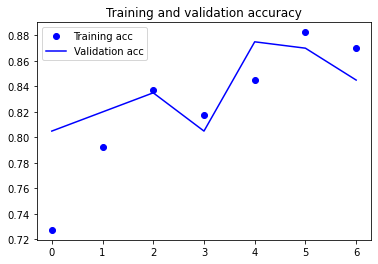

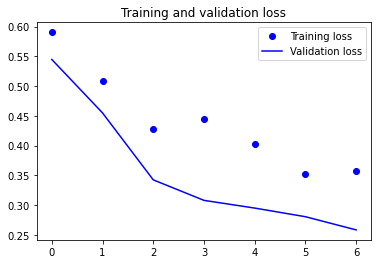

<Figure size 432x288 with 0 Axes>

In [11]:
history = model.fit(
      train_generator,
      steps_per_epoch=20,
      epochs=7,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2)


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
plt.clf()

And now test the model. Note that since in test_generator we defined the batch size it will be generating data in batches. Thus since it works infinitely we need to say when to stop generating batches. Which is what "step" argument is for. Notice that 20 steps (batches) by 20 examples in the batch is exactly 400 - as many as we have test examples!  

In [18]:
test_loss, test_acc = model.evaluate(test_generator, steps=20)
print('test acc:', test_acc)

20/20 [==============================] - 64s 3s/step - loss: 0.4362 - acc: 0.7700
test acc: 0.7699999809265137


Now let's run a cheaper option of exactly the same procedure: it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow the use of data augmentation.<br>

## Deciding after preprocessing (extracting features) with pretrained NN
Let us try the second option - use the convolutional base as preprocessor. First we need to extrarct features by running VGG16 over our training data set. We have feature extractor function for this. The function does the following 
<ol>
    <li>Prepare the tensor with extracted features for each training sample and corresponding label vector</li>
    <li> Generate the dataset stream using ImageDataGenerator as explained before. Note that for feature extraction the directory is passed as argument</li>
    <li> Next we predict feature maps from the data set without classifying it. The network still uses pre-learned weights and we still iterate over batches to obtain feature maps without classifying them. There cannot beany data augmentation - each image will be run oover exactly once.</li>
    <li>Note that since generators yield data indefinitely in a loop we must `break` after every image has been seen once</li>
</ol>


In [19]:
def extract_features(directory, sample_count, batch_size = 20):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        #if i>=38:
        #   print(i)
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

Now we can use the feature extracion function to extract features for training testing and validations.Each extracted feature map takes 150× 150 with 3 channels and output is 4×4×512 (4 channels, 512 neurons each, 4 parallel layers in a block). But the classification network  takes a vector. So we need to flatten the tensor into flat vector suitable for FF dense layer that we use next for classification. We do so using numpy reshape function 

In [20]:
train_features, train_labels = extract_features(train_dir, 800)
validation_features, validation_labels = extract_features(validation_dir, 400)
test_features, test_labels = extract_features(test_dir, 800)
train_features = np.reshape(train_features, (800, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (400, 4 * 4 * 512))
test_features = np.reshape(test_features, (800, 4 * 4 * 512))

Found 800 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


Finally, we do decision with shallow FF dense network just like we did for MINST letters data. It consists of RelU layer, dropout layer and sigmoid layer. We already have an extensive feature extraction so fo global features should be quickly synthesized.
<br>
Note a new wrinkle – use of dropout layer. It randomly sets input wieghts to 0 with a frequency of the <em>𝑟𝑎𝑡𝑒</em> argument (0.5) at each step during training time. Thus we are dropping some inputs altogether, which will cause the weights of the network to be larger than they should be. To prevent that the rescaling of the weights is performed at training time, after each weight update at the end of the mini-batch. The weights incident to inputs that are not set to 0 are re-scaled down by dividing by 1/(1 − 𝑟𝑎𝑡𝑒) so that the sum over all edges is unchanged. The dropout layer only applies when training is set to True! No values are dropped during actual inference. 
<ul>
    <li> When using model.fit, training will be set to True automatically,</li>
    <li> When using model.predict  it is automatically set to False, </li>
    <li> In other contexts we can explicitly set to True or False when calling the layer.</li>
<ul>

In [22]:
decision_model = models.Sequential()
decision_model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
decision_model.add(layers.Dropout(0.5))
decision_model.add(layers.Dense(1, activation='sigmoid'))

decision_model.compile(optimizer= tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

decision_history = decision_model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


40/40 [==============================] - 1s 17ms/step - loss: 0.6582 - acc: 0.6150 - val_loss: 0.5590 - val_acc: 0.7550
Epoch 2/30
40/40 [==============================] - 1s 14ms/step - loss: 0.5106 - acc: 0.7563 - val_loss: 0.4905 - val_acc: 0.7900
Epoch 3/30
40/40 [==============================] - 1s 15ms/step - loss: 0.4449 - acc: 0.8112 - val_loss: 0.4460 - val_acc: 0.8075
Epoch 4/30
40/40 [==============================] - 1s 15ms/step - loss: 0.3960 - acc: 0.8413 - val_loss: 0.4124 - val_acc: 0.8250
Epoch 5/30
40/40 [==============================] - 1s 15ms/step - loss: 0.3773 - acc: 0.8438 - val_loss: 0.3846 - val_acc: 0.8400
Epoch 6/30
40/40 [==============================] - 1s 15ms/step - loss: 0.3446 - acc: 0.8662 - val_loss: 0.3805 - val_acc: 0.8250
Epoch 7/30
40/40 [==============================] - 1s 15ms/step - loss: 0.3016 - acc: 0.8737 - val_loss: 0.3521 - val_acc: 0.8550
Epoch 8/30
40/40 [==============================] - 1s 15ms/step - loss: 0.2789 - acc: 0.9050 

See how many more epochs I am able to do this way - training decision layer separately on data allows me to save considerable time acheiving result better than top to bottom running of the netwrok for training. Now let's plot the loss and accuracy for training and validation respectively.

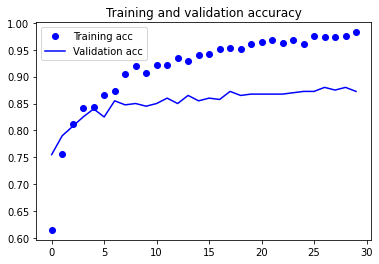

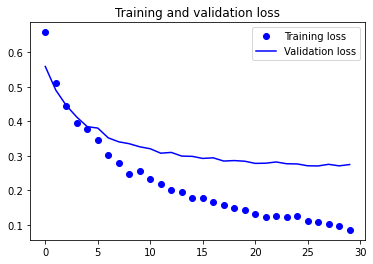

<Figure size 432x288 with 0 Axes>

In [23]:
d_acc = decision_history.history['acc']
d_val_acc = decision_history.history['val_acc']
d_loss = decision_history.history['loss']
d_val_loss = decision_history.history['val_loss']

d_epochs = range(len(d_acc))

plt.plot(d_epochs, d_acc, 'bo', label='Training acc')
plt.plot(d_epochs, d_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(d_epochs, d_loss, 'bo', label='Training loss')
plt.plot(d_epochs, d_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
plt.clf()

I expect the results of testing to be better for the reason that we afforded more training of decision layer. So let' 

In [24]:
d_results = decision_model.evaluate(test_features, test_labels)
print(d_results)

25/25 [==============================] - 0s 6ms/step - loss: 0.3335 - acc: 0.8450
[0.3335472345352173, 0.8450000286102295]


# True End-to-End decision that includes training convolutional layers of VGG16
Everything including model is the same as before. Except before we set "conv_base.trainable = True". More exactly:
<ol>
    <li>If we look at VGG16 it consists of 5 convolutional blocks. First 4 blocks are leaning small features and the last block is summarizing features. Snce generic local features (e.g. geometric features such as graph of locations of corners on a picture) are presumably the same for all pictures of animated objects</li>
    <li>The more parameters we are training, the more is overfitting risk! So we should train only necessary</li>
    <li>Training more parameters requires more time. Each new parameter contributes exponentially</li>
</ol>
Thus we are better off not tatraining layers 1-4. So we only need to unfreeze for training the block 5. Otherwise the models are the same.  

In [25]:
e_to_e_model = models.Sequential()
e_to_e_model.add(conv_base)
e_to_e_model.add(layers.Flatten())
e_to_e_model.add(layers.Dense(256, activation='relu'))
e_to_e_model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = True

Fine-tuning block 5 means that all layers up until and including block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable.

In [26]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

The the hyperparameters of the model and performance indicator remains the same as they were with end-to-end training with frozen VGG16 weights, except for one notable exception: in the model compilation the learning rate of RMSprop optimizer is set extremely low (1e-5). The reason for it is that magnitude of modifications to feature maps of layers in block 5 needs to be limited if we want not to loose the features learned in pretraining

In [27]:
e_to_e_model.compile(loss='binary_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

e_to_e_history = e_to_e_model.fit(
      train_generator,
      steps_per_epoch=20,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


20/20 - 112s - loss: 0.5853 - acc: 0.6900 - val_loss: 0.5434 - val_acc: 0.7200 - 112s/epoch - 6s/step
Epoch 2/10
20/20 - 110s - loss: 0.4419 - acc: 0.8175 - val_loss: 0.4620 - val_acc: 0.7950 - 110s/epoch - 6s/step
Epoch 3/10
20/20 - 109s - loss: 0.3151 - acc: 0.9025 - val_loss: 0.3745 - val_acc: 0.8300 - 109s/epoch - 5s/step
Epoch 4/10
20/20 - 109s - loss: 0.2545 - acc: 0.9025 - val_loss: 0.3577 - val_acc: 0.8250 - 109s/epoch - 5s/step
Epoch 5/10
20/20 - 110s - loss: 0.1908 - acc: 0.9375 - val_loss: 0.2557 - val_acc: 0.9150 - 110s/epoch - 6s/step
Epoch 6/10
20/20 - 109s - loss: 0.1710 - acc: 0.9550 - val_loss: 0.3147 - val_acc: 0.8650 - 109s/epoch - 5s/step
Epoch 7/10
20/20 - 109s - loss: 0.1371 - acc: 0.9675 - val_loss: 0.3103 - val_acc: 0.8650 - 109s/epoch - 5s/step
Epoch 8/10
20/20 - 109s - loss: 0.1013 - acc: 0.9850 - val_loss: 0.2555 - val_acc: 0.8900 - 109s/epoch - 5s/step
Epoch 9/10
20/20 - 109s - loss: 0.0808 - acc: 0.9725 - val_loss: 0.2939 - val_acc: 0.8750 - 109s/epoch - 5s

Now plotting and testing

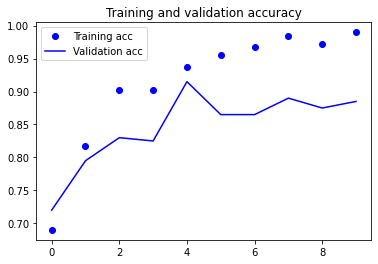

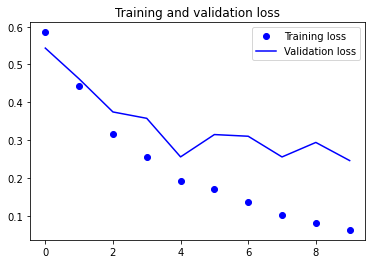

<Figure size 432x288 with 0 Axes>

In [28]:
e_acc = e_to_e_history.history['acc']
e_val_acc = e_to_e_history.history['val_acc']
e_loss = e_to_e_history.history['loss']
e_val_loss = e_to_e_history.history['val_loss']

e_epochs = range(len(e_acc))

plt.plot(e_epochs, e_acc, 'bo', label='Training acc')
plt.plot(e_epochs, e_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(e_epochs, e_loss, 'bo', label='Training loss')
plt.plot(e_epochs, e_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
plt.clf()

In [29]:
e_test_loss, e_test_acc = e_to_e_model.evaluate(test_generator, steps=20)
print('test acc:', e_test_acc)

20/20 [==============================] - 65s 3s/step - loss: 0.1697 - acc: 0.9150
test acc: 0.9150000214576721
